In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src')
from utils import *
from collections import Counter

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm

from darts.utils.statistics import check_seasonality
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel

sns.set(font_scale=1)
sns.set_style('white')
sns.set_style('ticks')

2023-08-11 22:20:58 darts.models WARNING: The statsforecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


# Dataset 

In [2]:

# df = pd.read_csv(os.path.join(data_dir,'Eartquakes-1990-2023.csv'))
# cnt = dict(Counter(pd.to_datetime(df['date']).dt.strftime('%Y-%m')))

# # Missing data in 2018
# cnt['2018-06'] = int(np.mean(list(cnt.values())))
# cnt['2018-07'] = int(np.mean(list(cnt.values())))
# cnt = dict(sorted(cnt.items(), reverse=False))

# data = pd.DataFrame(list(cnt.values()), columns=['Global_active_power']).astype(float)
# data['Date'] = pd.to_datetime(list(cnt.keys()))

# data = data.set_index('Date')

# print(data.info())
# data.head()

In [4]:
data_dir = '../data'
data = pd.read_csv(os.path.join(data_dir,'household_power_consumption.txt'), 
                   sep = ';',
                   parse_dates={'dt':['Date','Time']}, 
                   infer_datetime_format=True,
                   na_values=['?', np.nan],
                   low_memory=False).rename(columns={"dt": "date"}).fillna(method='ffill')

data = data.iloc[:300,:]
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   300 non-null    datetime64[ns]
 1   Global_active_power    300 non-null    float64       
 2   Global_reactive_power  300 non-null    float64       
 3   Voltage                300 non-null    float64       
 4   Global_intensity       300 non-null    float64       
 5   Sub_metering_1         300 non-null    float64       
 6   Sub_metering_2         300 non-null    float64       
 7   Sub_metering_3         300 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 18.9 KB
None


,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


# Seasonality and periodicity check

In [9]:
data['Date'] = data.index
series = TimeSeries.from_dataframe(data, 'Date', 'Global_active_power')# , fill_missing_dates=True, freq=None
is_seasonal, seq_len = check_seasonality(series, max_lag=240)
dict_seas ={'is seasonal?':is_seasonal, 'periodicity (months)':f'{seq_len:.1f}'}
_ = [print(k,':',v) for k,v in dict_seas.items()]

data["rolling_avg"] = data["Global_active_power"].rolling(window=seq_len).mean()
data["rolling_std"] = data["Global_active_power"].rolling(window=seq_len).std()
df, df_test = data.iloc[:data.shape[0]-2*seq_len, :], data.iloc[data.shape[0]-2*seq_len:, :]

is seasonal? : True
periodicity (months) : 10.0


# Decomposition

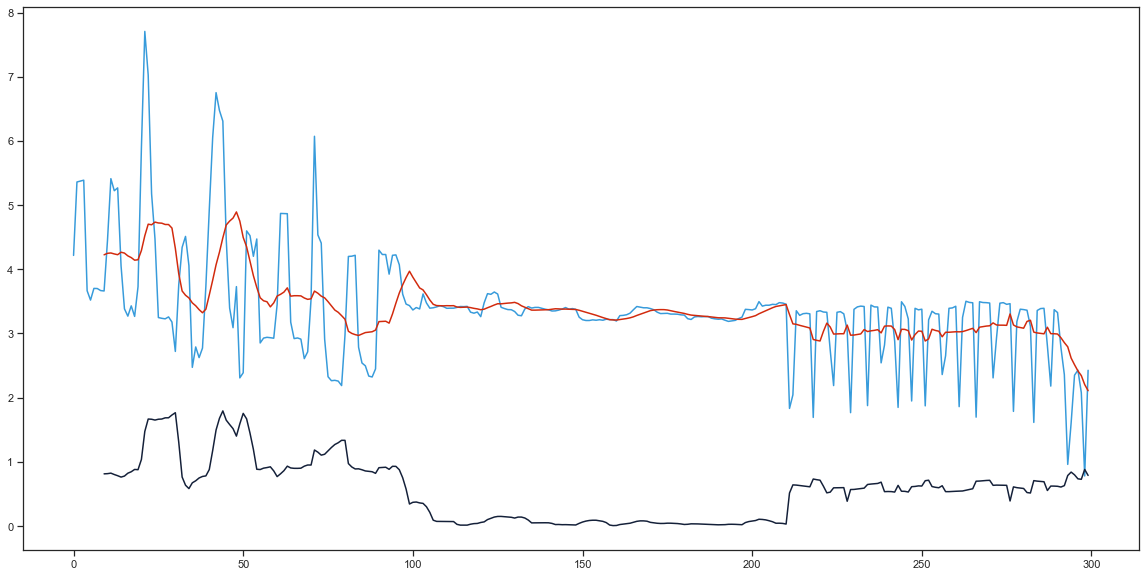

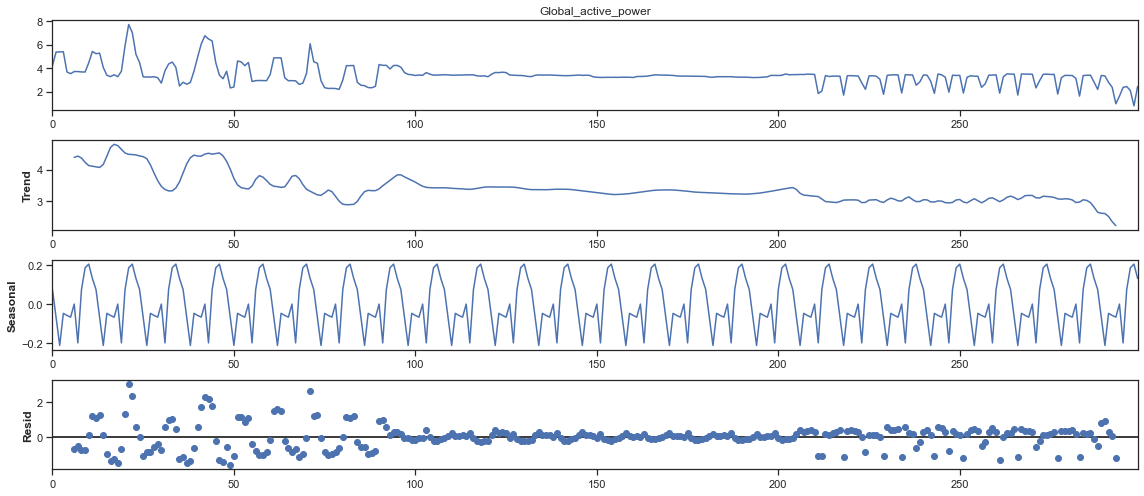

In [11]:
seq_len=12
ssn = seasonal_decompose(data['Global_active_power'], model='additive', period=seq_len)

plt.figure(figsize=(20,10))
# plt.subplot(1,2,1)
plt.plot(data['Global_active_power'], color='#379BDB', label='Original')
plt.plot(data['rolling_avg'], color='#D22A0D', label='Rolling Mean')
plt.plot(data['rolling_std'], color='#142039', label='Rolling Std')
# plt.subplot(1,2,2)
# month = [str('%02d'%(i)) for i in range(1,13)]
# cnt = [np.sum([r['Global_active_power'] for idx, r in data.iterrows() if str(idx).split('-')[1]==d]) for d in month]# df['Global_active_power'].values
# plt.bar(month, cnt, color='#379BDB')

plt.rc('figure', figsize=(16, 7))
plt.rc('font', size=10)
fig = ssn.plot()
plt.show()

# Stationarity test

In [12]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(data['Global_active_power'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -1.837518
p-value                          0.362000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64


# Auto ARIMA / SARIMA / SARIMAX approach

In [14]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df['Global_active_power'], 
                            start_p=1, 
                            start_q=1,
                            test='adf', # use adftest to find optimal 'd'
                            max_p=3, max_q=3, # maximum p and q
                            m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            d=None,# let model determine 'd'
                            seasonal=False, # No Seasonality for standard ARIMA
                            trace=False, #logs 
                            error_action='warn', #shows errors ('ignore' silences these)
                            suppress_warnings=True,
                            stepwise=True)

SARIMA_model = pm.auto_arima(df['Global_active_power'], start_p=1, start_q=1,
                             test='adf',
                             max_p=3, max_q=3, 
                             m=12, #12 is the frequncy of the cycle
                             start_P=0, 
                             seasonal=True, #set to seasonal
                             d=None, 
                             D=1, #order of the seasonal differencing
                             trace=False,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

# #adding exogenous variable
# df['month_index'] = df.index.month
# SARIMAX_model = pm.auto_arima(df[['Global_active_power']],
#                               exogenous=df[['month_index']],
#                               start_p=1, start_q=1,
#                               test='adf',
#                               max_p=3, max_q=3, m=12,
#                               start_P=0, seasonal=True,
#                               d=None, D=1, 
#                               trace=False,
#                               error_action='ignore',  
#                               suppress_warnings=True, 
#                               stepwise=True)

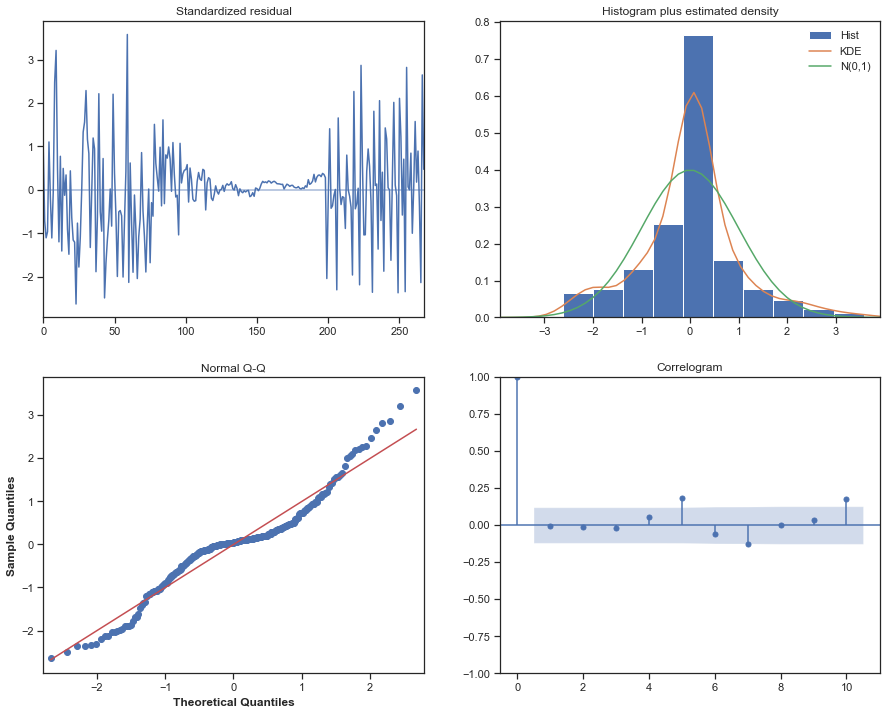

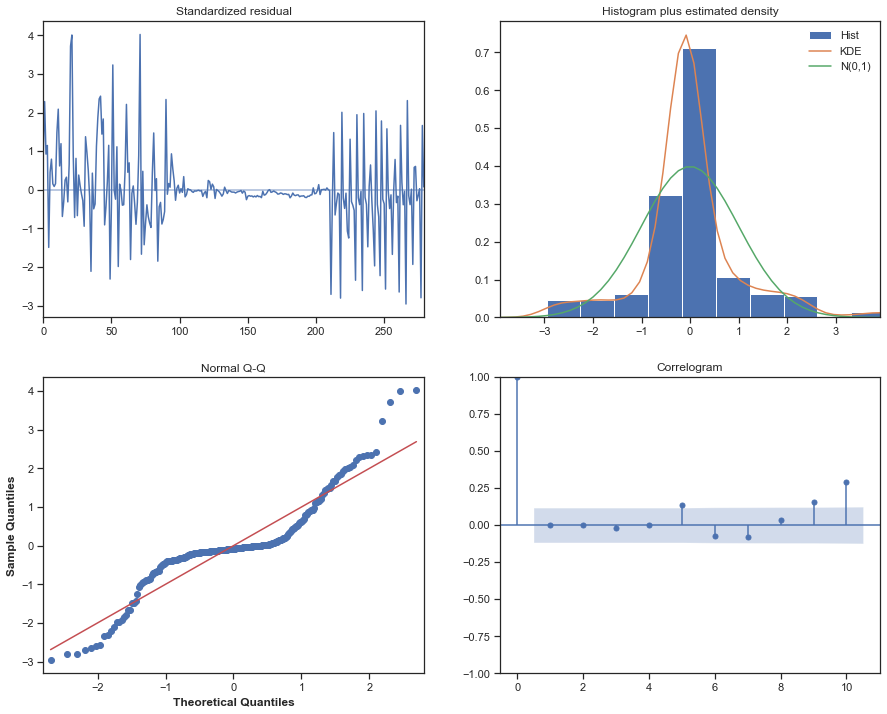

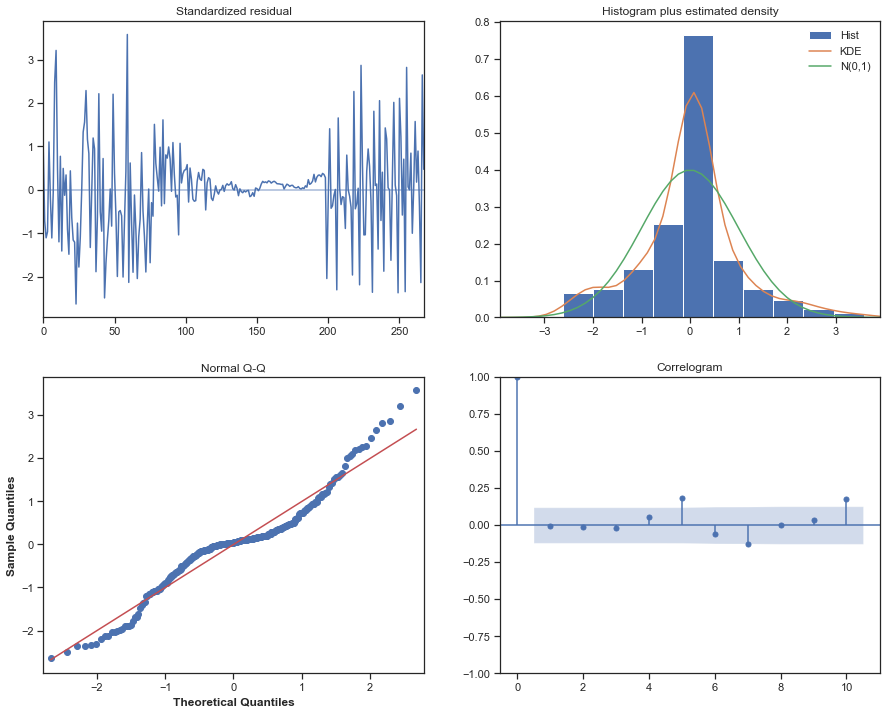

In [15]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
SARIMA_model.plot_diagnostics(figsize=(15,12))
# SARIMAX_model.plot_diagnostics(figsize=(15,12))

In [16]:
pred_arima, _, _ = arima_forecast(ARIMA_model, df, periods=df_test.shape[0])
eval_arima = metrics_sklearn(df_test['Global_active_power'].values, pred_arima.values)

pred_sarima, _, _ = arima_forecast(SARIMA_model, df, periods=df_test.shape[0])
eval_sarima = metrics_sklearn(df_test['Global_active_power'].values, pred_sarima.values)

# pred_sarimax, _, _ = sarimax_forecast(SARIMAX_model, df, periods=df_test.shape[0])
# eval_sarimax = metrics_sklearn(df_test['Global_active_power'].values, pred_sarimax.values)

# plt.figure(figsize=(15,7))
# plt.plot(df['Global_active_power'], color='#1f76b4')
# plt.plot(df_test['Global_active_power'], color='red')
# plt.plot(pred_arima, color='darkgreen')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
# plt.title('ARIMA - Forecast of champagne Global_active_powers')
# plt.show()

TypeError: unsupported operand type(s) for +: 'int' and 'DateOffset'

# Deep learning approach

In [ ]:
split_date = df_test.index[0]
train, val = series.split_after(pd.Timestamp(split_date))

In [ ]:
scaler = Scaler()

train_scaled = scaler.fit_transform(train)
series_scaled, val_scaled = scaler.transform(series), scaler.transform(val)

# create month and year covariate series
year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000), attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
covariates = year_series.stack(month_series)

In [ ]:
forecast = df_test.shape[0]

model_lstm = fit_model('LSTM', series_scaled, train_scaled, val_scaled, seq_len)
pred_lstm = scaler.inverse_transform(model_lstm.predict(n=forecast, future_covariates=covariates))
eval_lstm = metrics_darts(pred_lstm, series)

model_gru = fit_model('GRU', series_scaled, train_scaled, val_scaled, seq_len)
pred_gru = scaler.inverse_transform(model_gru.predict(n=forecast, future_covariates=covariates))
eval_gru = metrics_darts(pred_gru, series)

model_rnn = fit_model('RNN', series_scaled, train_scaled, val_scaled, seq_len)
pred_rnn = scaler.inverse_transform(model_rnn.predict(n=forecast, future_covariates=covariates))
eval_rnn = metrics_darts(pred_rnn, series)

# Evaluation

In [ ]:
keys = ['mae', 'mape', 'mse', 'rmse', '-r2_score']
d = {'arima':eval_arima,
     'sarima':eval_sarima,
     'sarimax':eval_sarimax,
     'lstm':eval_lstm,
     'gru':eval_gru,
     'rnn':eval_rnn} 

res = pd.DataFrame({k:[i[k] for i in d.values()] for k in keys})
res.index = d.keys()
white = green = [{'selector': 'th', 'props': 'background-color: white'}]
res.style.set_properties(**{'background-color': 'white'}).highlight_min(color='lightgreen').highlight_max(color='red').set_table_styles({k: white for k in res.index}, axis=1)

In [ ]:
# dropout = 0.2
# window_size = seq_len - 1
# batch_size = 16

In [23]:
# scaler = MinMaxScaler()
# price = df['Global_active_power'].values.reshape(-1, 1)
# scaled_price = scaler.fit_transform(price)

# X_train, y_train, X_val, y_val = get_train_test_sets(scaled_price, seq_len, train_frac=0.8)

In [24]:
# price = df_test['Global_active_power'].values.reshape(-1, 1)
# scaled_price_test = scaler.fit_transform(price)
# X = split_into_sequences(scaled_price_test, seq_len)
# X_test, y_test = X[:, :-1, :], X[:, -1, :]

In [25]:
# metrics = [MeanSquaredError(), MeanAbsoluteError()]

# # build a 3-layer LSTM RNN
# model = keras.Sequential()
# model.add(LSTM(window_size, return_sequences=True, input_shape=(window_size, X_train.shape[-1])))
# model.add(Dropout(rate=dropout))# Bidirectional allows for training of sequence data forwards and backwards
# model.add(Bidirectional(LSTM((window_size * 2), return_sequences=True))) 
# model.add(Dropout(rate=dropout))
# model.add(Bidirectional(LSTM(window_size, return_sequences=False))) 
# model.add(Dense(units=1))
# model.add(Activation('linear'))
# model.compile(loss='mean_squared_error', optimizer='adam', metrics = metrics)

In [26]:
# callbacks_list = [EarlyStopping(patience=50),
#                   ReduceLROnPlateau(monitor='val_loss',
#                                     factor=0.2,
#                                     patience=5,
#                                     min_lr=0.001)]
# history = model.fit(X_train,
#                     y_train,
#                     epochs=500,
#                     batch_size=batch_size,
#                     shuffle=False,
#                     callbacks=callbacks_list,
#                     validation_data=(X_val, y_val),
#                     verbose=0)

# plt.figure(figsize=(15,7))
# plt.rcParams.update({'font.size': 15})

# plt.plot(history.history['loss'], label='train_loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.legend()

# plt.tight_layout()

In [27]:
# y_pred = scaler.inverse_transform(model.predict(X_test))
# pred = pd.Series(y_pred.reshape(-1)).set_axis(list(df_test.index)[:y_pred.shape[0]])
# # y_pred = scaler.inverse_transform(model.predict(y_test))
# # pred_y = pd.Series(y_pred.reshape(-1)).set_axis(list(df_test.index)[:y_test.shape[0]])

# plt.figure(figsize=(15,7))
# plt.plot(df['Global_active_power'], color='#1f76b4', label='Historical Global_active_power')
# plt.plot(df_test['Global_active_power'], color='red', label='Actual Global_active_power')
# plt.plot(pred, color='darkgreen', label='Predicted Global_active_power')
# # plt.plot(pred_y, color='darkblue', label='Predicted Global_active_power')
# plt.legend()
# plt.show()

In [28]:
# y_test.shape

In [29]:
# print('Test MAE  : %.3f'%mean_absolute_error(list(df_test['Global_active_power'].values)[:y_pred.shape[0]], pred.values))
# print('Test MSE  : %.3f'% mean_squared_error(list(df_test['Global_active_power'].values)[:y_pred.shape[0]], pred.values))

In [ ]:
plt.figure(figsize=(15,10))
series.plot(label='actual', color='#1f76b4')
pred_lstm.plot(label='prediction LSTM', color='red')
pred_gru.plot(label='prediction GRU', color='green')
pred_rnn.plot(label='prediction RNN', color='orange')
plt.plot(pred_arima, color='darkgreen', label='prediction ARIMA')
plt.plot(pred_sarima, color='purple', label='prediction SARIMA')
plt.plot(pred_sarimax, color='cyan', label='prediction SARIMAX')
plt.legend()
plt.show()